In [23]:
!pip install pycm livelossplot
%pylab inline

from itertools import product
import os
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['product', 'mean', 'random', 'std']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [24]:
def set_seed(seed):
    """Set ALL the random seeds to a fixed value and take out any randomness from cuda kernels."""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms.
                                            # Useful when inputs do not change size.
    torch.backends.cudnn.enabled   = False

    return True

In [25]:
def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")

Cuda installed! Running on GPU 0 NVIDIA A100-SXM4-40GB!


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Specify the csv folder path
csv_folder_path = "/content/drive/MyDrive/Storm_Project/storm_data_csv"

# Get a list of all files in the folder
files = [file for file in os.listdir(csv_folder_path) if file.endswith('.csv')]

# Create an empty DataFrame to store the data
all_data = pd.DataFrame()

# Loop through each file and read it into the DataFrame
for file in files:
    file_path = os.path.join(csv_folder_path, file)
    df = pd.read_csv(file_path)
    all_data = pd.concat([all_data, df], ignore_index=True)

all_data['relative_time'] = all_data['relative_time'].astype(int)
all_data['ocean'] = all_data['ocean'].astype(int)
all_data['wind_speed'] = all_data['wind_speed'].astype(int)

all_data

,storm_id,relative_time,ocean,wind_speed,image_file_name
0,ztb,0,1,38,ztb_000.jpg
1,ztb,1799,1,38,ztb_001.jpg
2,ztb,3600,1,39,ztb_002.jpg
3,ztb,5401,1,39,ztb_003.jpg
4,ztb,7200,1,40,ztb_004.jpg
...,...,...,...,...,...
9522,bkh,1022400,1,30,bkh_405.jpg
9523,bkh,1026001,1,30,bkh_406.jpg
9524,bkh,1027801,1,30,bkh_407.jpg
9525,bkh,1029601,1,30,bkh_408.jpg


In [28]:
class StormDataset(Dataset):
    def __init__(self, train_df, storm_id, num_sequence, img_folder_path):
        self.df = train_df[train_df['storm_id'] == storm_id]
        self.storm_id = storm_id
        self.image_file_names = self.df['image_file_name'].to_numpy()
        self.img_folder_path = img_folder_path
        self.num_sequence = num_sequence
        # self.resize_image()  # Resize to (366, 366) in size
        self.imgs_not_normalised = [self.get_image_not_normalised(f) for f in self.image_file_names]
        self.mean = torch.mean(torch.stack(self.imgs_not_normalised) / 255.).item()
        self.std = torch.std(torch.stack(self.imgs_not_normalised) / 255.).item()
        self.imgs = [((img/255.) - self.mean)/self.std for img in self.imgs_not_normalised]

    def get_image_not_normalised(self, img_filename):
        img = read_image(self.img_folder_path + '/' + img_filename).float()
        return img

    def get_sub_series_of_images(self, start, num_img):
        imgs = torch.stack(self.imgs[start: (start+num_img)], dim=0)
        return imgs

    def resize_image(self):
        pass

    def __len__(self):
        return len(self.df) - self.num_sequence

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            start = idx.start or 0
            stop = idx.stop or len(self.df) - self.num_sequence
            step = idx.step or 1
            return [
                (
                    self.get_sub_series_of_images(i, self.num_sequence),
                    self.get_sub_series_of_images(i + self.num_sequence, 1)
                )
                for i in range(start, stop, step)
            ]
        else:
            return (
                self.get_sub_series_of_images(idx, self.num_sequence),
                self.get_sub_series_of_images(idx + self.num_sequence, 1)
            )

In [29]:
# The training data to be transformed to a PyTorch tensor
storm = "bkh"
num_sequence=10
bkh = StormDataset(all_data, storm, num_sequence=num_sequence, img_folder_path="/content/drive/MyDrive/Storm_Project/all_storm_image")
mean, std = bkh.mean, bkh.std
print(f"The images of the {storm} storm with last {num_sequence} images have the mean of {bkh.mean} and the SD of {bkh.std}.")

The images of the bkh storm with last 10 images have the mean of 0.27985233068466187 and the SD of 0.2152128517627716.


In [30]:
train_set = bkh[:int(len(bkh)*0.8)]
val_set = bkh[int(len(bkh)*0.8):]
train_loader = DataLoader(train_set, batch_size=2, shuffle=False)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)

In [31]:
for i in train_loader:
    print(i[0].shape)
    print(i[1].shape)
    break

torch.Size([2, 10, 1, 366, 366])
torch.Size([2, 1, 1, 366, 366])


In [32]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialise a convolutional Long short-term memory (ConvLSTM) cell.

        Parameters
        ----------
        input_dim: int
            The number of channels of an input tensor.
        hidden_dim: int
            The number of channels of a hidden state.
        kernel_size: (int, int)
            The size of a convolutional kernel.
        bias: bool
            The choice to be chosen whether a bias is included in the model.
        """
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim+self.hidden_dim,
            out_channels=4*self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, img_size):
        """Initialise a hidden state."""
        height, width = img_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))



class EncoderDecoderConvLSTM(nn.Module):
    def __init__(self, input_chan):
        """
        Parameters
        ----------
        input_chan: int

            The number of channels of the input.

        """
        super(EncoderDecoderConvLSTM, self).__init__()

        # ConvLSTM encoders
        self.convlstm_encoders = nn.ModuleList([
            ConvLSTMCell(input_dim=input_chan, hidden_dim=4, kernel_size=(3, 3), bias=True),
            ConvLSTMCell(input_dim=4, hidden_dim=16, kernel_size=(3, 3), bias=True),
        ])

        # ConvLSTM decoders
        self.convlstm_decoders = nn.ModuleList([
            ConvLSTMCell(input_dim=16, hidden_dim=8, kernel_size=(3, 3), bias=True),
            ConvLSTMCell(input_dim=8, hidden_dim=5, kernel_size=(3, 3), bias=True),
            ConvLSTMCell(input_dim=5, hidden_dim=3, kernel_size=(3, 3), bias=True),
        ])

        # 3D-CNN decoders
        self.cnn_decoders = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=3, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.Conv3d(in_channels=3, out_channels=1, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
        )

        # self.batch_norm1 = nn.BatchNorm2d(16)

    def autoencoder(self, X, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4, h_t5, c_t5):
        """
        Parameters
        ----------
        X: torch.Tensor

            An input tensor with shape (batch_size, sequence_length, channels, height, width).

        seq_len: int

            The length of the input sequence.

        future_step: int

            The number of future steps to predict.

        h_t, h_t2, h_t3, h_t4, h_t5: torch.Tensors

            Hidden states for different ConvLSTM layers.

        c_t, c_t2, c_t3, c_t4, c_t5: torch.Tensors

            Cell states for different ConvLSTM layers.

        Returns
        -------
        outs: list of torch.Tensors

            The list of predicted outputs for each future step.

        """
        outs = []
        # ConvLSTM encoders
        for t in range(seq_len):
            h_t, c_t = self.convlstm_encoders[0](input_tensor=X[:, t, :, :], cur_state=[h_t, c_t])
            h_t2, c_t2 = self.convlstm_encoders[1](input_tensor=h_t, cur_state=[h_t2, c_t2])
        # ConvLSTM decoders - take the encoder vector (h_t2) as input
        for t in range(future_step):
            h_t3, c_t3 = self.convlstm_decoders[0](input_tensor=h_t2, cur_state=[h_t3, c_t3])
            h_t4, c_t4 = self.convlstm_decoders[1](input_tensor=h_t3, cur_state=[h_t4, c_t4])
            h_t5, c_t5 = self.convlstm_decoders[2](input_tensor=h_t4, cur_state=[h_t5, c_t5])
            outs.append(h_t5)  # Predictions

        outs = torch.stack(outs, 1)
        outs = outs.permute(0, 2, 1, 3, 4)
        outs = self.cnn_decoders[0](outs)
        outs = nn.Tanh()(outs)
        outs = self.cnn_decoders[1](outs)

        return outs

    def forward(self, X, future_step=1):
        """
        Parameters
        ----------
        X: torch.Tensor

            An input tensor with shape (batch_size, sequence_length, channels, height, width).

        future_step: int

            The number of future steps to predict.

        Returns
        -------
        out: torch.Tensor

            The final predicted outputs of the model.

        """

        # find size of different input dimensions
        b, seq_len, _, h, w = X.size()

        # initialize hidden states
        h_t, c_t = self.convlstm_encoders[0].init_hidden(batch_size=b, img_size=(h, w))
        h_t2, c_t2 = self.convlstm_encoders[1].init_hidden(batch_size=b, img_size=(h, w))
        h_t3, c_t3 = self.convlstm_decoders[0].init_hidden(batch_size=b, img_size=(h, w))
        h_t4, c_t4 = self.convlstm_decoders[1].init_hidden(batch_size=b, img_size=(h, w))
        h_t5, c_t5 = self.convlstm_decoders[2].init_hidden(batch_size=b, img_size=(h, w))

        # autoencoder forward
        out = self.autoencoder(X, seq_len, future_step, h_t, c_t, h_t2, c_t2, h_t3, c_t3, h_t4, c_t4, h_t5, c_t5)
        return out

In [33]:
print("Size of X:", X.size())

NameError: name 'X' is not defined

In [34]:
def train(train_loader, optimizer, criterion, model, device):
    model.train()
    train_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss/len(train_loader)
    return avg_train_loss

In [35]:
def validate(val_loader, criterion, model, device):
    model.eval()
    val_loss = 0
    for X, y in val_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X)
            loss = criterion(a2.view(-1, 366*366), y.view(-1, 366*366))
            val_loss += loss*X.size(0)

    avg_val_loss = val_loss/len(val_loader)
    return avg_val_loss

In [36]:
set_seed(0)
model = EncoderDecoderConvLSTM(input_chan=1).to(device)

In [37]:
lr = 1e-3
n_epochs = 2
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [38]:
X.shape

NameError: name 'X' is not defined

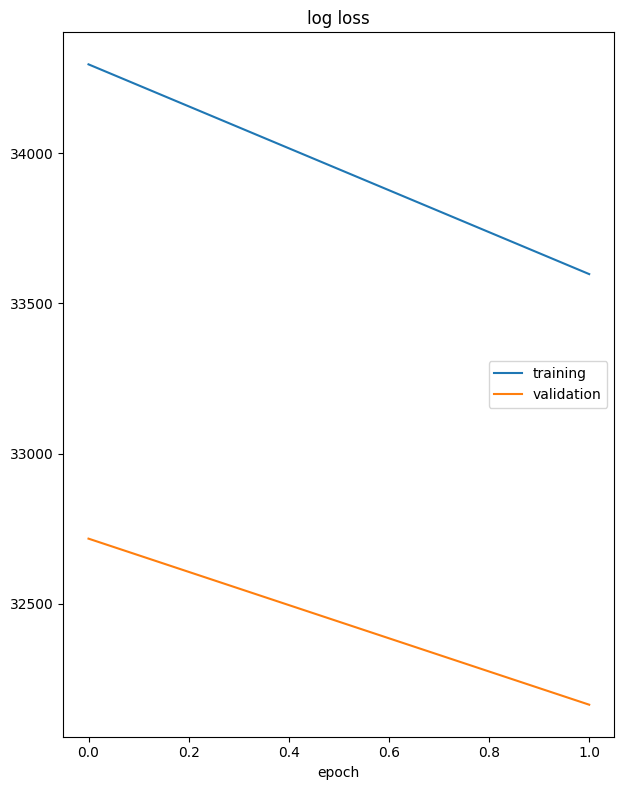

log loss
	training         	 (min: 33597.582, max: 34296.066, cur: 33597.582)
	validation       	 (min: 32163.701, max: 32716.686, cur: 32163.701)


In [47]:
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train(train_loader, optimizer, criterion, model, device)
    print(epoch, train_loss)
    logs['' + 'log loss'] = train_loss.item()
    logs['val_'+ 'log loss'] = validate(val_loader, criterion, model, device).item()
    liveloss.update(logs)
    liveloss.draw()

Structural imilarity = 0.8567167273525595
MSE = 0.0050381773417389345


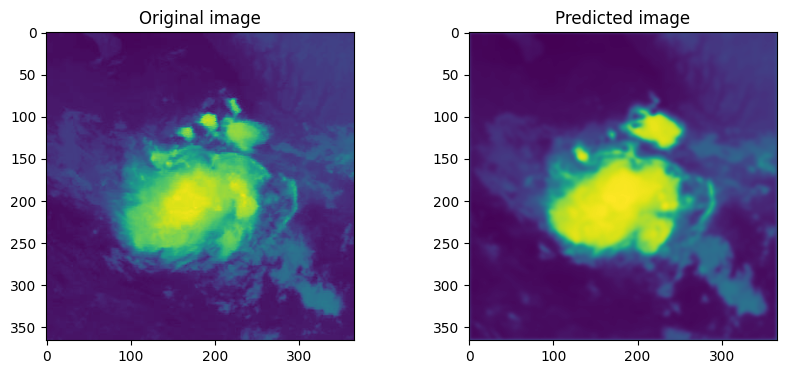

In [40]:
model.eval()

for X, y in val_loader:
    X = X.to(device)

    y = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()
    y_pred = model(X)
    y_pred = (y_pred.view(-1, 366, 366)[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].imshow(y)
    axs[0].set(title="Original image")
    axs[1].imshow(y_pred)
    axs[1].set(title="Predicted image")

    similarity = ssim(y_pred, y)
    error = mse(y_pred, y)
    print("Structural imilarity =", similarity)
    print("MSE =", error)

    break

In [48]:
model.eval()

# Number of images to predict
num_images_to_predict = 3

for X, y in val_loader:
    X = X.to(device)

    # Store the ground truth images for comparison later
    original_images = [(y[0, 0, 0, :, :].detach().cpu().numpy() * std + mean)]

    # Predict the next num_images_to_predict images
    for _ in range(num_images_to_predict):
        # Assuming X has shape (batch_size, seq_len, channels, height, width)
        y_pred = model(X)
        original_images.append((y_pred.view(-1, 366, 366)[0, :].detach().cpu().numpy() * std + mean))
        # Use the predicted image for the next iteration
        X = y_pred.unsqueeze(1)

    # Plot
    fig, axs = plt.subplots(1, num_images_to_predict + 1, figsize=(15, 4))

    for i in range(num_images_to_predict + 1):
        axs[i].imshow(original_images[i])
        axs[i].set(title=f"Image {i}")

    # Calculate and print metrics for the last predicted image
    similarity = ssim(original_images[-1], original_images[-2])
    error = mse(original_images[-1], original_images[-2])
    print(f"Structural similarity for Image {num_images_to_predict} =", similarity)
    print(f"MSE for Image {num_images_to_predict} =", error)

    break


ValueError: too many values to unpack (expected 5)

In [41]:
import torch
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)


In [43]:
print(X.shape)

torch.Size([2, 10, 1, 366, 366])


In [45]:
model.eval()

# Number of images to predict
num_images_to_predict = 3

for X, y in val_loader:
    X = X.to(device)

    # Store the ground truth images for comparison later
    original_images = [(y[0, 0, 0, :, :].detach().cpu().numpy() * std + mean)]

    # Predict the next num_images_to_predict images
    for _ in range(num_images_to_predict):
        # Assuming X has shape (batch_size, seq_len, channels, height, width)
        try:
            y_pred = model(X)
        except Exception as e:
            print(f"Error: {e}")
            print(f"Shape of X: {X.shape}")
            raise

        original_images.append((y_pred.view(-1, 366, 366)[0, 0].detach().cpu().numpy() * std + mean))
        # Use the predicted image for the next iteration
        X = y_pred.unsqueeze(1)

    # Plot
    fig, axs = plt.subplots(1, num_images_to_predict + 1, figsize=(15, 4))

    for i in range(num_images_to_predict + 1):
        axs[i].imshow(original_images[i])
        axs[i].set(title=f"Image {i}")

    # Calculate and print metrics for the last predicted image
    similarity = ssim(original_images[-1], original_images[-2])
    error = mse(original_images[-1], original_images[-2])
    print(f"Structural similarity for Image {num_images_to_predict} =", similarity)
    print(f"MSE for Image {num_images_to_predict} =", error)

    break


Error: too many values to unpack (expected 5)
Shape of X: torch.Size([2, 1, 1, 1, 366, 366])


ValueError: too many values to unpack (expected 5)

In [ ]:
# From ChatGPT
def generate_combinations(dictionary):
    """Create combinations of values attached to each key in a given dictionary."""

    keys = list(dictionary.keys())
    values = list(dictionary.values())

    # Generate all possible combinations of values
    combinations = list(product(*values))

    # Create a list of dictionaries using the combinations
    result = [dict(zip(keys, combination)) for combination in combinations]

    return result

In [ ]:
# Create all possible combination of hyperparameters
hyperparams_dict = {
    "lr": [1e-3, 1.5e-3, 2e-3],
}
hyperparams_combinations = generate_combinations(hyperparams_dict)

In [ ]:
# Loop over all the combinations
for hyperparams in hyperparams_combinations:
    # Set model and hyperparameters
    set_seed(0)
    model = EncoderDecoderConvLSTM(input_chan=1).to(device)
    lr = hyperparams['lr']
    n_epochs = 10
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    # Loop to train
    for _ in range(n_epochs):
        train_losses.append(train(train_loader, optimizer, criterion, model, device).item())
        val_losses.append(validate(val_loader, criterion, model, device).item())

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(range(1, n_epochs+1), train_losses, label='training')
    ax.plot(range(1, n_epochs+1), val_losses, label='validation')
    ax.set(title='Log loss', xlabel='# Epoch')
    plt.show()

    model.eval()

    for X, y in val_loader:
        X = X.to(device)

        y = (y[0, 0, 0, :, :]*std + mean).detach().cpu().numpy()
        y_pred = model(X)
        y_pred = (y_pred.view(-1, 366, 366)[0, :]*std + mean).detach().cpu().numpy()  # (366, 366)

        # Plot
        fig2, axs = plt.subplots(1, 2, figsize=(10, 4))
        axs[0].imshow(y)
        axs[0].set(title="Original image")
        axs[1].imshow(y_pred)
        axs[1].set(title="Predicted image")
        plt.show()

        similarity = ssim(y_pred, y)
        error = mse(y_pred, y)
        print("Structural similarity =", similarity)
        print("MSE =", error)

        break